<a href="https://colab.research.google.com/github/sidneyarcidiacono/fastai-practical-deep-learning/blob/main/notebooks/snake_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.7MB/s 
     |████████████████████████████████| 194kB 13.0MB/s 
     |████████████████████████████████| 1.1MB 20.1MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
Mounted at /content/gdrive


In [20]:
from fastbook import *
from fastai.vision.widgets import *

In [21]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'bd220979600745d3b0f6aa712b11d062')

In [45]:
results = search_images_bing(key, 'python')
ims = results.attrgot('content_url')
len(ims)

150

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
#hide
ims = ['https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fupload.wikimedia.org%2Fwikipedia%2Fcommons%2Fthumb%2Fb%2Fb4%2FPython_reticulatus_%25D1%2581%25D0%25B5%25D1%2582%25D1%2587%25D0%25B0%25D1%2582%25D1%258B%25D0%25B9_%25D0%25BF%25D0%25B8%25D1%2582%25D0%25BE%25D0%25BD-2.jpg%2F1200px-Python_reticulatus_%25D1%2581%25D0%25B5%25D1%2582%25D1%2587%25D0%25B0%25D1%2582%25D1%258B%25D0%25B9_%25D0%25BF%25D0%25B8%25D1%2582%25D0%25BE%25D0%25BD-2.jpg&f=1&nofb=1']

In [48]:
dest = 'drive/MyDrive/snake-images/python.jpg'
download_url(ims[0], dest)

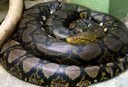

In [49]:
im = Image.open(dest)
im.to_thumb(128,128)

In [50]:
snake_types = 'python','viper','cobra'
path = Path('snakes')

In [51]:
if not path.exists():
    path.mkdir()
    for o in snake_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} snake')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [52]:
fns = get_image_files(path)
fns

(#418) [Path('snakes/cobra/00000120.jpg'),Path('snakes/cobra/00000003.jpg'),Path('snakes/cobra/00000073.jpg'),Path('snakes/cobra/00000137.jpg'),Path('snakes/cobra/00000017.jpg'),Path('snakes/cobra/00000127.jpg'),Path('snakes/cobra/00000122.jpg'),Path('snakes/cobra/00000034.jpg'),Path('snakes/cobra/00000046.jpg'),Path('snakes/cobra/00000052.jpg')...]

In [53]:
failed = verify_images(fns)
failed

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(#0) []

In [54]:
failed.map(Path.unlink);

In [55]:
snakes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [56]:
dls = snakes.dataloaders(path)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


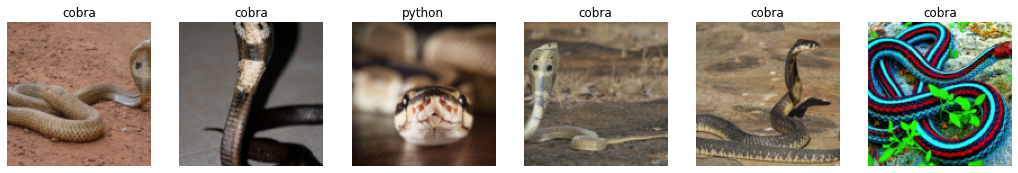

In [57]:
dls.valid.show_batch(max_n=6, nrows=1)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


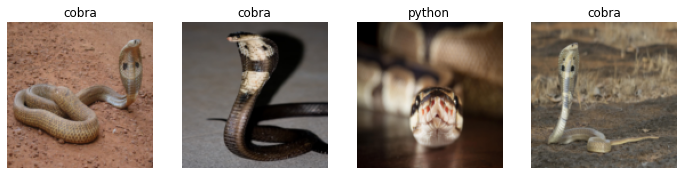

In [58]:
snakes = snakes.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = snakes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


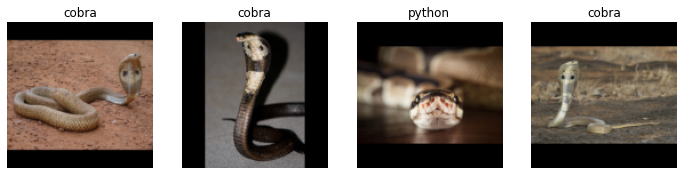

In [59]:
snakes = snakes.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = snakes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [60]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.865557,2.206048,0.518072,00:14


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


epoch,train_loss,valid_loss,error_rate,time
0,1.221804,1.333641,0.493976,00:14
1,0.979963,1.259285,0.433735,00:14
2,0.787690,1.198718,0.433735,00:13
3,0.666386,1.141144,0.409639,00:14


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


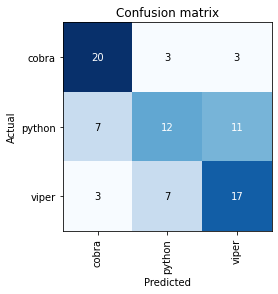

In [61]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

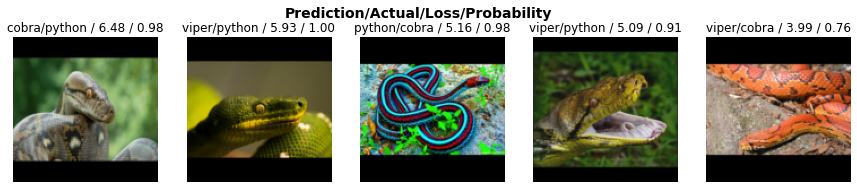

In [62]:
interp.plot_top_losses(5, nrows=1)

In [65]:
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: ignored

In [64]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Error: ignored